# Modelling Customer Lifetime Value (CLV) Using BG/NBD and Gamma-Gamma (non-contractual)

The data was accessed from Kaggle via the following link: https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_order_items_dataset.csv

This is a Brazilian e-commerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates. 

For the CLV models:
+ Frequency is number of repeat purchases by a customer (total number of purchases - 1).
+ T is customer age in whatever time units chosen (duration between a customer’s first purchase and the end of the period under study).
+ Recency is customer age when they made their most recent purchases (duration between a customer’s first purchase and their latest purchase, so if they have made only 1 purchase, recency = 0)

The lifetimes package, developed by Cameron Davidson-Pilon, enables this analysis.

This is non-contractual.

In [1]:
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

from lifetimes.plotting import *
from lifetimes.utils import *
#from lifetimes.estimation import *

In [2]:
#import data
orders = pd.read_csv('data/olist_orders_dataset.csv')
items = pd.read_csv('data/olist_order_items_dataset.csv')
cust = pd.read_csv('data/olist_customers_dataset.csv')

In [3]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [5]:
cust.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
#number of orders per customer
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

In [7]:
#merge orders and customers
orders = pd.merge(orders, cust[['customer_id','customer_unique_id']], on='customer_id')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [8]:
#drop duplicate order ids
items.drop_duplicates('order_id', keep='first', inplace=True)

In [9]:
#merge with items
data = pd.merge(orders, items, how='inner', on='order_id')
data = data[['customer_unique_id', 'order_purchase_timestamp', 'price']]

#convert timestamp to date, retain date only
data['date'] = pd.to_datetime(data['order_purchase_timestamp']).dt.date
data = data.drop('order_purchase_timestamp', axis=1)
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')

data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


In [10]:
data.shape

(98666, 3)

In [11]:
#check for nulls
data.isnull().sum()

customer_unique_id    0
price                 0
date                  0
dtype: int64

In [12]:
#check no negative prices
data[(data['price'] <= 0)]

,customer_unique_id,price,date


In [13]:
print('Number of unique customers:', data['customer_unique_id'].nunique())

Number of unique customers: 95420


In [14]:
print('Number of Entries: %s' % len(data))

Number of Entries: 98666


In [15]:
#find date range
print('Minimum date:', min(data.date))
print('Maximum date:', max(data.date))

Minimum date: 2016-09-04 00:00:00
Maximum date: 2018-09-03 00:00:00


### Data Exploration

In [16]:
#summary_data_from_transaction_data generates CLV data
data_clv = summary_data_from_transaction_data(data, 'customer_unique_id', 'date', monetary_value_col='price', datetime_format='%Y/%m/%d', observation_period_end='2018-09-03')
data_clv.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


In [17]:
data_clv.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


From the head of the dataframe, all 5 customers have only made a single transaction thus their frequency is 0, with age being the number of days since their single purchase.

Proportion of customers who have made only a single purchase:  0.9781492349612241


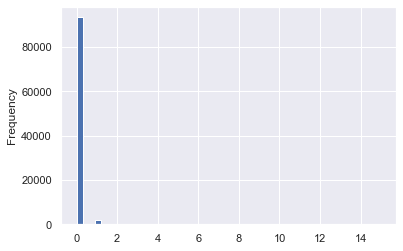

In [18]:
data_clv['frequency'].plot(kind='hist', bins=50)
print('Proportion of customers who have made only a single purchase: ', sum(data_clv['frequency'] == 0)/float(len(data_clv)))

The above shows that 97.8% of customers have only made a single transaction.

## Frequency/Recency analysis using the BG/NBD model

The BG-NBD (Beta Geometric Negative Binomial Distribution) model is described in the paper “Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Model by Fader et al. in 2005.

The model can be used to determine expected repeat visits for customers in order to determine a customers lifetime value. It can also be used to determine whether a customer has churned or is likely to churn soon.

The model is already implemented in the lifetimes package.

There are a number of assumptions made by this model:
1. While active, transactions made by a customer in time period t is Poisson distributed with mean λt
2. Differences in transaction rate between customers follows a gamma distribution with shape r and scale α
3. Each customer becomes inactive after each transaction with probability p
4. Differences in p follows a beta distribution with shape parameters a and b
5. Transaction rate and dropout probability vary independently between customers

In [19]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data_clv['frequency'], data_clv['recency'], data_clv['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>


#### Visualising the frequency/recency matrix

The relationship between sales frequency and probability of being alive can be visualised using the Frequency/Recency matrix, which computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

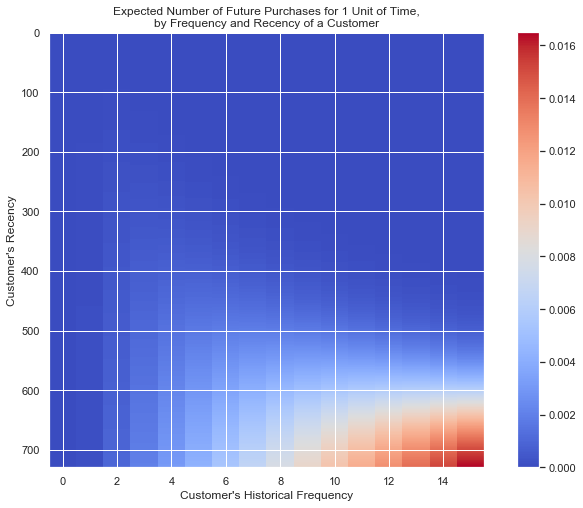

In [20]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

This plot shows that if a customer has bought 14 times or more from the company, and they were 700 days old or above when they made their most recent purchase, then they are the company's best customer. This makes logical sense - the longer they have been buying and the higher their purchase frequency, the more they have spent with with the company. Customers who have purchased a lot and purchased recently will likely be the best customers in the future.

Customers who have purchased a lot but not recently may have dropped out.

The white tail represents customers who buy infrequently, have not purchased recently, and may have dropped out or just be between purchases.

Using plot_probability_alive_matrix, which customers are still alive can be predicted.

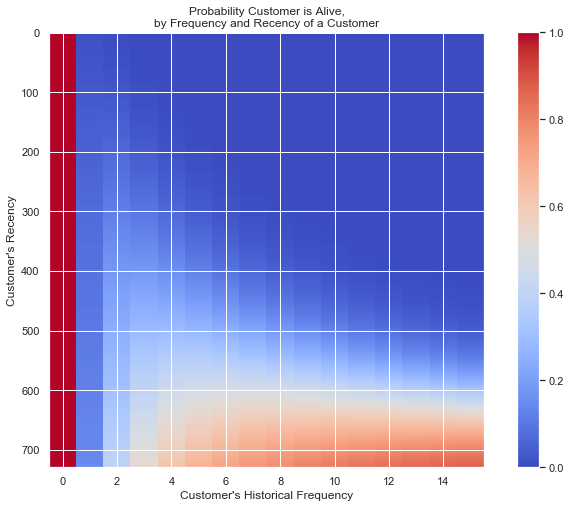

In [21]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

The more recently a customer has made a purchase the higher the likelihood that they are still alive/not dropped out. 

Customers who have purchased a lot but not recently, are likely to have dropped out. The higher their historical purchases, the more likely they have dropped out.

Customers can be ranked from best to worst based on highest expected purchases in the next period to lowest, predicted using their purchase history.

In [22]:
t = 1
data_clv['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data_clv['frequency'], data_clv['recency'], data_clv['T'])
data_clv.sort_values(by = 'predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
customer_unique_id,,,,,
e0836a97eaae86ac4adc26fbb334a527,2.0,62.0,69.0,24.245,0.005503
6469f99c1f9dfae7733b25662e7f1782,5.0,282.0,349.0,106.880,0.005613
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,429.0,75.552,0.006605
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,255.0,106.150,0.006981
8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,476.0,47.642,0.022795


The customer ranked as 'best' is 8d50f5eadf50201ccdcedfb9e2ac8455, as they have historically made 15 purchases, and have bought recently, but only have a 2% probability of buying in the next period.

### Assessing model fit

The first method of assessing the model's correctness is to compare the data with artificial data simulated with the fitted model’s parameters.

#### Calibration period histogram

This will help determine how well the model fits the training data.

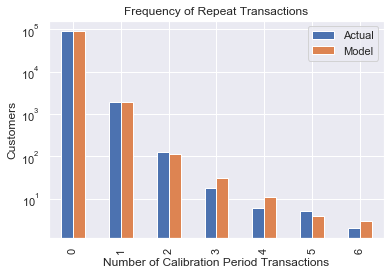

In [23]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf).set_yscale('log'); #log used due to small no. customers with > 1 transactions

The model is fairly representation of the real data up until 3 repeat transactions. There are few customers who make more purchases.

#### Cumulative transaction plot

The dataset can be partitioned into a calibration period dataset and a holdout dataset to test how the model performs on unseen data. This can be done with lifetimes calibration_and_holdout_data.

This data will help detemine whether the model predicts cumulative sales well or not.

In [24]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

summary_cal_holdout = calibration_and_holdout_data(data, 'customer_unique_id', 'date',
                                        calibration_period_end='2017-09-03',
                                        observation_period_end='2018-09-03' )   
print(summary_cal_holdout.head())

                                  frequency_cal  recency_cal  T_cal  \
customer_unique_id                                                    
0000f46a3911fa3c0805444483337064            0.0          0.0  177.0   
0005e1862207bf6ccc02e4228effd9a0            0.0          0.0  183.0   
0006fdc98a402fceb4eb0ee528f6a8d4            0.0          0.0   47.0   
000a5ad9c4601d2bbdd9ed765d5213b3            0.0          0.0   23.0   
000de6019bb59f34c099a907c151d855            0.0          0.0   17.0   

                                  frequency_holdout  duration_holdout  
customer_unique_id                                                     
0000f46a3911fa3c0805444483337064                0.0               365  
0005e1862207bf6ccc02e4228effd9a0                0.0               365  
0006fdc98a402fceb4eb0ee528f6a8d4                0.0               365  
000a5ad9c4601d2bbdd9ed765d5213b3                0.0               365  
000de6019bb59f34c099a907c151d855                0.0               365 

In [25]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 22741 subjects, a: 2.36, alpha: 38.76, b: 0.28, r: 0.01>

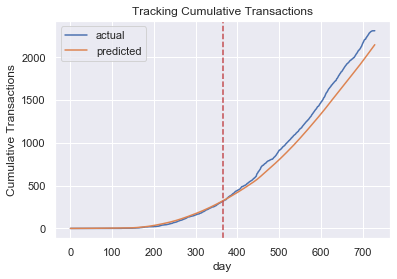

In [26]:
plot_cumulative_transactions(bgf, data, 'date', 'customer_unique_id', 730, 365);

The red line represents the boundary between the calibration period on the left and the holdout period on the right. The BG/NBD model does a good job at predicting cumulative transactions.

#### Incremental transaction plot

This is used to help determine if the model captures the overall trend in transactions.

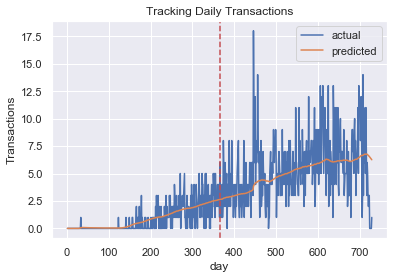

In [27]:
plot_incremental_transactions(bgf, data, 'date', 'customer_unique_id', 730, 365);

#### Conditional expectations plot

This will help determine if the model can predict the number of purchases a customer will make based on the training data.

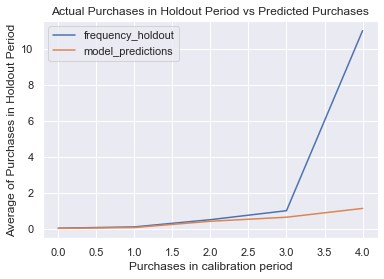

In [28]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

The model appears to performs well up to three calibration period purchases, but diverges from the holdout data due to the distribution of the data.

Much of the inaccuracies can most likely be at least partly blamed on the small number of customers with more than 1 transaction. In practice, more data should be collected (customers or over time).

## Customer Predictions

Based on customer history, what an individual's future purchases might look like can be predicted:

In [29]:
t = 10 #predict purchases in 10 periods
individual = data_clv.loc['8d50f5eadf50201ccdcedfb9e2ac8455']
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.22863247376848186

In [30]:
data_clv.loc['8d50f5eadf50201ccdcedfb9e2ac8455']

frequency               15.000000
recency                462.000000
T                      476.000000
monetary_value          47.642000
predicted_purchases      0.022795
Name: 8d50f5eadf50201ccdcedfb9e2ac8455, dtype: float64

In [31]:
t = 10 #predict purchases in 10 periods
individual = data_clv.loc['e0836a97eaae86ac4adc26fbb334a527']
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.05614940817046436

In [32]:
data_clv.loc['e0836a97eaae86ac4adc26fbb334a527']

frequency               2.000000
recency                62.000000
T                      69.000000
monetary_value         24.245000
predicted_purchases     0.005503
Name: e0836a97eaae86ac4adc26fbb334a527, dtype: float64

The model predicts that, in 10 time periods, customer 8d50f5eadf50201ccdcedfb9e2ac8455's future transaction is 0.23, and customer e0836a97eaae86ac4adc26fbb334a527's future transaction is 0.06.

## Modelling churn risk

The BG/NBD model assumes that death can only occur after a repeat purchase, since the customer leaving occurs during a purchase and the first purchase is reserved to signal a customer’s birth.

Because of this, customers with only one transactions will have a 100% probability of being alive, which is questionable. To account for this limitation, churn risk will only be predicted on customers who have made at least one repeat transaction.

In [33]:
returning_customers_summary = data_clv[data_clv['frequency'] > 0]

print(returning_customers_summary.head())
print(len(returning_customers_summary))

                                  frequency  recency      T  monetary_value  \
customer_unique_id                                                            
004288347e5e88a27ded2bb23747066c        1.0    171.0  403.0           87.90   
004b45ec5c64187465168251cd1c9c2f        1.0    267.0  367.0           27.00   
0058f300f57d7b93c477a131a59b36c3        1.0     31.0  196.0           72.58   
00a39521eb40f7012db50455bf083460        1.0     11.0  103.0           11.55   
011575986092c30523ecb71ff10cb473        1.0     60.0  198.0           63.90   

                                  predicted_purchases  
customer_unique_id                                     
004288347e5e88a27ded2bb23747066c             0.000170  
004b45ec5c64187465168251cd1c9c2f             0.000271  
0058f300f57d7b93c477a131a59b36c3             0.000227  
00a39521eb40f7012db50455bf083460             0.000428  
011575986092c30523ecb71ff10cb473             0.000286  
2085


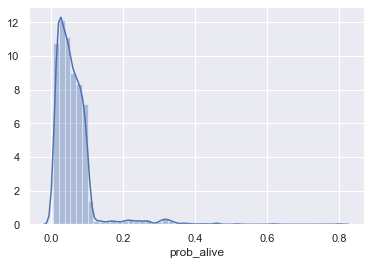

In [34]:
returning_customers_summary['prob_alive'] = bgf.conditional_probability_alive(returning_customers_summary['frequency'],returning_customers_summary['recency'],returning_customers_summary['T'])
sns.distplot(returning_customers_summary['prob_alive']);

From here, customers can be visualised based on the probability that they are “alive”. Using domain knowledge it might be possible to set a threshold for customers who probably have already churned, and identify customers who are at risk for churning, but have not yet disappeared.

Next, a decision threshold for customer churn will be set. This is an opportunity to inject personal expertise or talk with domain experts. For purposes here, a customer with <10% chance of being alive is assumed to have churned.

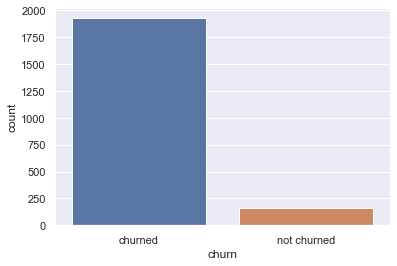

In [35]:
returning_customers_summary['churn'] = ['churned' if p < .1 else 'not churned' for p in returning_customers_summary['prob_alive']]
sns.countplot(returning_customers_summary['churn']);

Slightly over 92% of customers have churned, meaning that there is a lot of opportunity for improvement regarding retention.

It is assumed that the customers who have churned are already lost. 

What a business would be interested in is the customers who are at high risk for churn, but have not churned yet. These can be identified for targeting.

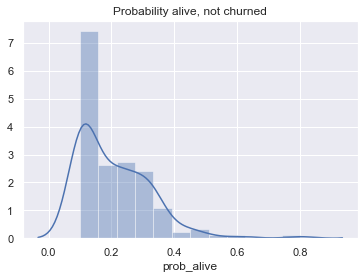

In [36]:
sns.distplot(returning_customers_summary[returning_customers_summary['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');

For purposes here, customers with 80% or more churn risk are considered high risk for churn.

In [37]:
returning_customers_summary['churn'][(returning_customers_summary['prob_alive']>=.1) & (returning_customers_summary['prob_alive']<.2)] = "high risk"
returning_customers_summary['churn'].value_counts()

churned        1928
high risk        84
not churned      73
Name: churn, dtype: int64

With these churn groupings, those at high risk can be targeted (and potentially even those who have supposedly churned by a different marketing approach). 

## Estimating CLV using Gamma-Gamma model of monetary value

Now, the economic value of each transaction will be taken into account. To estimate this, the Gamma-Gamma submodel, presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton, is used to predict likely spend per transaction in the future at the customer level.

Only the customers who had at least one repeat purchase with the company are estimated.

### The Gamma-Gamma model and independence assumption

The model used to estimate CLV for customers is the Gamma-Gamma submodel, which relies upon an important assumption - that there is no relationship between monetary value and purchase frequency. In practice this should be checked as to whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [38]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,-0.013334
frequency,-0.013334,1.000000


The above shows that the correlation is very close to 0, so at this point the Gamma-Gamma submodel can be trained and used to predict the conditional, expected average lifetime value of the customers.

In [39]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2085 subjects, p: 2.98, q: 2.90, v: 72.16>


In [40]:
print(ggf.conditional_expected_average_profit(
        data_clv['frequency'],
        data_clv['monetary_value']
    ).head(10))

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    113.030015
0000b849f77a49e4a4ce2b2a4ca5be3f    113.030015
0000f46a3911fa3c0805444483337064    113.030015
0000f6ccb0745a6a4b88665a16c9f078    113.030015
0004aac84e0df4da2b147fca70cf8255    113.030015
0004bd2a26a76fe21f786e4fbd80607f    113.030015
00050ab1314c0e55a6ca13cf7181fecf    113.030015
00053a61a98854899e70ed204dd4bafe    113.030015
0005e1862207bf6ccc02e4228effd9a0    113.030015
0005ef4cd20d2893f0d9fbd94d3c0d97    113.030015
dtype: float64


In [41]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        data_clv['frequency'],
        data_clv['monetary_value']
    ).mean(),
    data_clv[data_clv['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 113.0311906194035, Average profit: 113.26364540367545


This can be adjusted to account for cost of capital using the customer_lifetime_value function:

In [42]:
bgf.fit(data_clv['frequency'], data_clv['recency'], data_clv['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data_clv['frequency'],
    data_clv['recency'],
    data_clv['T'],
    data_clv['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1.944432
0000b849f77a49e4a4ce2b2a4ca5be3f    1.923923
0000f46a3911fa3c0805444483337064    0.796569
0000f6ccb0745a6a4b88665a16c9f078    1.129799
0004aac84e0df4da2b147fca70cf8255    1.207843
0004bd2a26a76fe21f786e4fbd80607f    1.730914
00050ab1314c0e55a6ca13cf7181fecf    1.815964
00053a61a98854899e70ed204dd4bafe    1.557559
0005e1862207bf6ccc02e4228effd9a0    0.790137
0005ef4cd20d2893f0d9fbd94d3c0d97    1.611123
Name: clv, dtype: float64
